In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

import scipy
from scipy.integrate import solve_ivp

from Calculation.geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from Calculation.material import StaticMaterial, Material, LayeredFilm, Hk2KuJ, print_Hext_parameters

In [2]:
from Calculation.EnergyEqs import DemagnetizationEnergy, StoenerWolfarthEnergy, StoenerWolfarth_2nd_order_Energy, IEC_Energy
   
demagnet_eq = DemagnetizationEnergy()
StWo_eq = StoenerWolfarthEnergy()
StWo_2nd_eq = StoenerWolfarth_2nd_order_Energy()
IEC_eq = IEC_Energy()


<AxesSubplot:xlabel='t'>

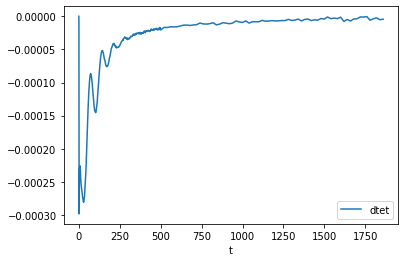

In [3]:
data_3825 = pd.read_csv('data/moke/single_3825Oe.txt', sep='\t')
data_3825.plot(x='t', y='dtet')

In [4]:
from Calculation.LLG_EQ import LLG_EQ

equation = LLG_EQ()

In [5]:
from Calculation.StationaryState import StationaryState   
        
st_state = StationaryState()

---------------------------------------------------
sample parametrs:
	J = 0.00

	layer1 parameters:
	PdFe
		Ku_1ord = 4.42e+06
		Ku_2ord = 1.30e+06
		Ms = 800.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000

	layer2 parameters:
	PdFe
		Ku_1ord = 4.42e+06
		Ku_2ord = 1.30e+06
		Ms = 800.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000
---------------------------------------------------


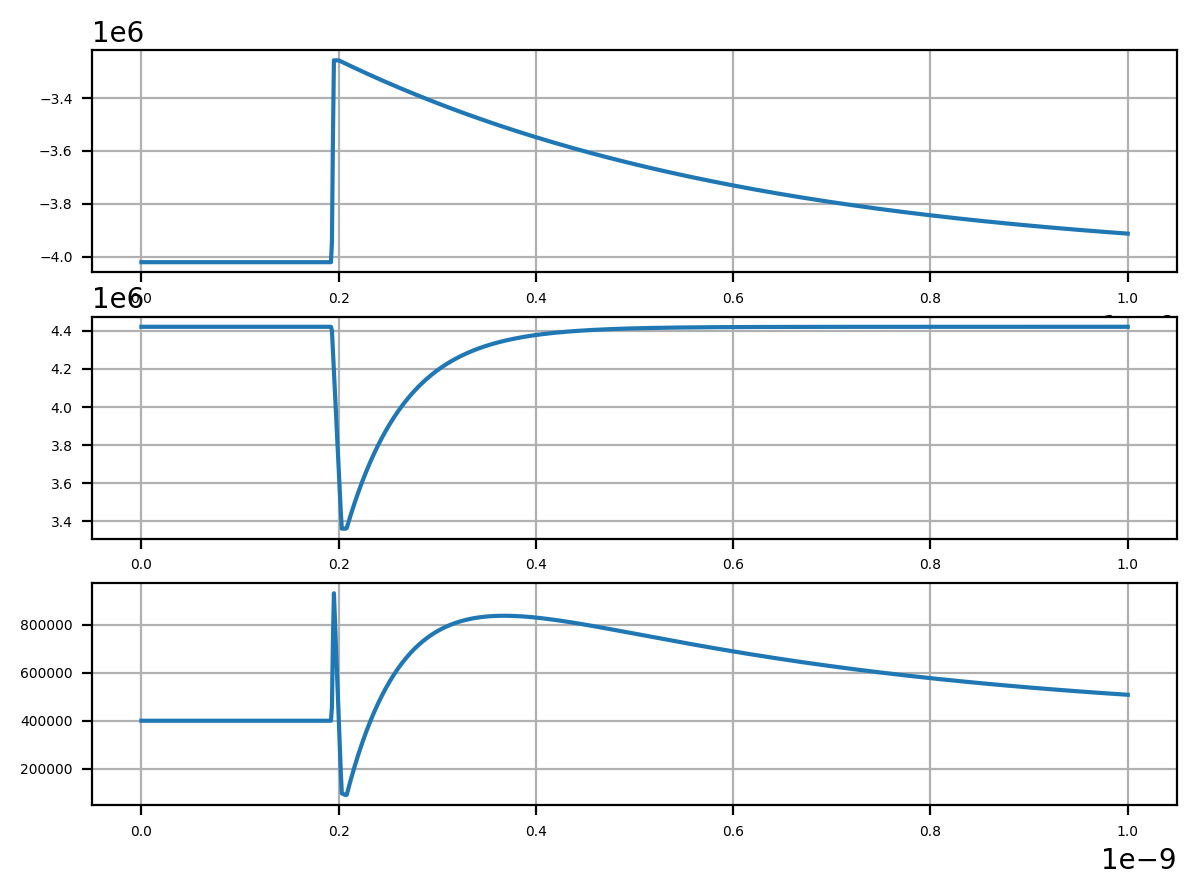

In [43]:
%matplotlib inline
#got from lihama article // single layer so H1=H2
#H1k1 = 13.1e3
#H1k2 = 1.2e3
#H2k = H1k1

H1k1 = 7.5e3
H1k2 = 6.5e3
H2k = 12.5e3

thickness = 12e-7
Ms_hyst = 800.

film_inst = LayeredFilm.from_file('default_double')
film_inst.update_with_Hk(H1k1, H1k2, H2k, Ms_hyst, zeroJ=True)
film_inst.print()

layer1 = film_inst.l1
layer2 = film_inst.l2

##dynamic parameters
#t_start = 2e-10
##M dynamic
#M_d =80
#M_tau = 240e-12
#M_t_grow = 2e-12
#M_t_stay = 5e-12
#M_t0 = t_start
##Ku dynamic
#Ku_d = Ku_1ord * (0.22)
#Ku_tau = 100e-12
#Ku_t_grow = 5e-12
#Ku_t_stay = 5e-12
#Ku_t0 = t_start + Ku_t_grow - M_t_grow + 0e-12

#dynamic parameters
t_start = 2e-10
#M dynamic
M_d = 80
M_tau = 400e-12
M_t_grow = 2e-12
M_t_stay = 5e-12
M_t0 = t_start
#Ku dynamic
Ku_d = film_inst.l1.st.Ku_1ord * (0.24)
Ku_tau = 60e-12
Ku_t_grow = 10e-12
Ku_t_stay = 5e-12
Ku_t0 = t_start + Ku_t_grow - M_t_grow + 0e-12


##dynamic parameters
#t_start = 2e-10
##M dynamic
#M_d = 80
#M_tau = 20e-12
#M_t_grow = 2e-12
#M_t_stay = 5e-12
#M_t0 = t_start
##Ku dynamic
#Ku_d = film_inst.l1.st.Ku_1ord * (0.2)
#Ku_tau = 100e-12
#Ku_t_grow = 8e-12
#Ku_t_stay = 5e-12
#Ku_t0 = t_start + Ku_t_grow - M_t_grow + 0e-12


#laser excitation
def Ku_func(t, Ku):
    t=np.array(t)
    res = np.array(t)
    res[t<Ku_t0-Ku_t_stay-Ku_t_grow] = Ku
    
    grow_cond = np.logical_and(t>Ku_t0-Ku_t_stay-Ku_t_grow, t<Ku_t0-Ku_t_stay)
    res[grow_cond] = Ku-(Ku_d/Ku_t_grow)*(t[grow_cond]-(Ku_t0-Ku_t_stay-Ku_t_grow))
    
    stay_cond = np.logical_and(t>Ku_t0-Ku_t_stay, t<Ku_t0)
    res[stay_cond] = Ku-Ku_d
    
    res[t>=Ku_t0] = Ku - Ku_d*np.exp(-(t[t>=Ku_t0]-Ku_t0)/Ku_tau)
    return res


layer1.set_Ku_1ord_lambda(lambda t: Ku_func(t, layer1.st.Ku_1ord))
layer2.set_Ku_1ord_lambda(lambda t: Ku_func(t, layer2.st.Ku_1ord))


fig, ax = plt.subplots(3, figsize=(7,5), dpi=200)
ax[0].grid()
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[2].grid()
ax[2].tick_params(axis='both', which='major', labelsize=5)


Ku_x_ax = np.linspace(0, 1000e-12, 1000)


def MsFrT(t):
    Ms_res = np.ones((len(t),)) * Ms_hyst
    
    Ms_grow_cond = np.logical_and(t>M_t0-M_t_stay-M_t_grow, t<M_t0-M_t_stay)
    Ms_res[Ms_grow_cond] = Ms_hyst-(M_d/M_t_grow)*(t[Ms_grow_cond] - (M_t0-M_t_stay-M_t_grow))
    
    Ms_stay_cond = np.logical_and(t<M_t0, t>M_t0-M_t_stay)
    Ms_res[Ms_stay_cond] = Ms_hyst-M_d
    
    Ms_res[t>M_t0] = Ms_hyst - M_d*np.exp(-(t[t>M_t0]-M_t0)/M_tau)
    return Ms_res
    

ax[0].plot(Ku_x_ax, -2*np.pi*(MsFrT(Ku_x_ax)**2))
ax[1].plot(Ku_x_ax, Ku_func(Ku_x_ax, layer1.st.Ku_1ord))
ax[2].plot(Ku_x_ax, Ku_func(Ku_x_ax, layer1.st.Ku_1ord)-2*np.pi*(MsFrT(Ku_x_ax)**2))


In [44]:
#external field
Hext_abs = 3e3
Hext_tet = np.deg2rad(63.)
Hext = np.array(pol2cart(Hext_abs, Hext_tet, 0.0))


film_inst.print()
print_Hext_parameters(Hext_abs, Hext_tet)



#model for solvation (Heff_function() + model())
def Heff_function(M1, M2, film, t):
    Heff1 = Hext + \
            demagnet_eq.Heff(M1) + \
            StWo_eq.Heff(M1, film.l1.Ku_1ord_l(t)) + \
            StWo_2nd_eq.Heff(M1, film.l1.Ku_2ord_l(t)) + \
            IEC_eq.Heff(M1, M2, film.J, film.l1.st.t)
        
    Heff2 = Hext + \
            demagnet_eq.Heff(M2) + \
            StWo_eq.Heff(M2, film.l2.Ku_1ord_l(t)) + \
            StWo_2nd_eq.Heff(M2, film.l2.Ku_2ord_l(t)) + \
            IEC_eq.Heff(M2, M1, film.J, film.l2.st.t)
    
    return Heff1, Heff2


def model(t,M1_M2):
    M1 = M1_M2[0:3]
    M2 = M1_M2[3:6]
    
    Heff1, Heff2 = Heff_function(M1, M2, film_inst, t)
    
    LLG1 = equation.right_hand(Heff1, M1, film_inst.l1, t)
    LLG2 = equation.right_hand(Heff2, M2, film_inst.l2, t)
    
    #addition of Ms derivative
    ort_M1 = M1/np.linalg.norm(M1)
    ort_M2 = M2/np.linalg.norm(M2)
    
    Ms_grow_cond = np.logical_and(t>M_t0-M_t_stay-M_t_grow, t<M_t0-M_t_stay)
    Ms_res[Ms_grow_cond] = Ms_hyst-(M_d/M_t_grow)*(t[Ms_grow_cond] - (M_t0-M_t_stay-M_t_grow))
    
    Ms_stay_cond = np.logical_and(t<M_t0, t>M_t0-M_t_stay)
    Ms_res[Ms_stay_cond] = Ms_hyst-M_d
    
    Ms_res[t>M_t0] = Ms_hyst - M_d*np.exp(-(t[t>M_t0]-M_t0)/M_tau)
    
    #condition on grow
    elif t>M_t0-M_t_grow-M_t_stay and t<M_t0-M_t_stay:
        LLG1 -= M_d/M_t_grow * ort_M1
        LLG2 -= M_d/M_t_grow * ort_M2
    
    #condition on remagnetization
    if t>M_t0:
        LLG1 += (M_d/M_tau)*np.exp(-(t-M_t0)/M_tau)*ort_M1
        LLG2 += (M_d/M_tau)*np.exp(-(t-M_t0)/M_tau)*ort_M2
    
    return np.append(LLG1, LLG2)


#estimating stationary position to start from
angles = st_state.get_angles_optimize_static(
    film_inst,
    Hext,
    tol=1e-8,
    #bounds= None, #default full range
    bounds = [(0, Hext_tet), (0, 2*np.pi), (np.deg2rad(120), np.pi), (0, 2*np.pi)] #for local minimums
)

print("tet1 = {:.4f},  phi1 = {:.4f}".format(np.rad2deg(angles[0]), np.rad2deg(angles[1])))
print("tet2 = {:.4f},  phi2 = {:.4f}".format(np.rad2deg(angles[2]), np.rad2deg(angles[3])))

M01 = pol2cart(film_inst.l1.st.Ms, angles[0] + np.deg2rad(0.0e-1), angles[1])
M02 = pol2cart(film_inst.l2.st.Ms, angles[2] - np.deg2rad(0.0e-1), angles[3])
M01_M02 = np.append(M01, M02)


time_span = [0.0, 1500.0e-12]
sol = solve_ivp(model, time_span, M01_M02, t_eval=np.linspace(time_span[0], time_span[1],int(1e5)),
                method = 'RK45', max_step=10e-14)




df = pd.DataFrame()
df['t'] = sol.t

df['x1'] = sol.y[0]
df['y1'] = sol.y[1]
df['z1'] = sol.y[2]
df['r1'] = np.sqrt(df['x1']**2+df['y1']**2+df['z1']**2)

df['x2'] = sol.y[3]
df['y2'] = sol.y[4]
df['z2'] = sol.y[5]
df['r2'] = np.sqrt(df['x2']**2+df['y2']**2+df['z2']**2)
df

---------------------------------------------------
sample parametrs:
	J = 0.00

	layer1 parameters:
	PdFe
		Ku_1ord = 4.42e+06
		Ku_2ord = 1.30e+06
		Ms = 800.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000

	layer2 parameters:
	PdFe
		Ku_1ord = 4.42e+06
		Ku_2ord = 1.30e+06
		Ms = 800.00
		t = 1.20e-06
		gamma = 1.86e+07
		alpha = 0.1000
---------------------------------------------------
---------------------------------------------------
External field:
	abs(H) = 3.00e+03
	tet(H) = 63.00
---------------------------------------------------
tet1 = 34.4238,  phi1 = 0.0000
tet2 = 121.2266,  phi2 = 0.0000


,t,x1,y1,z1,r1,x2,y2,z2,r2
0,0.000000e+00,452.248162,0.000000,659.902720,800.000000,684.099105,0.000000,-414.738972,800.000000
1,1.500015e-14,452.248163,-0.000005,659.902720,800.000000,684.099104,-0.000001,-414.738972,800.000000
2,3.000030e-14,452.248163,-0.000011,659.902719,800.000000,684.099104,-0.000003,-414.738973,800.000000
3,4.500045e-14,452.248163,-0.000016,659.902719,800.000000,684.099104,-0.000004,-414.738973,800.000000
4,6.000060e-14,452.248164,-0.000022,659.902719,800.000000,684.099104,-0.000006,-414.738973,800.000000
...,...,...,...,...,...,...,...,...,...
99995,1.499940e-09,446.470506,-0.143277,660.189796,796.985884,670.349756,0.859728,-431.064919,796.985884
99996,1.499955e-09,446.470728,-0.143272,660.189786,796.986000,670.350264,0.859707,-431.064345,796.986000
99997,1.499970e-09,446.470950,-0.143267,660.189776,796.986117,670.350772,0.859685,-431.063770,796.986117
99998,1.499985e-09,446.471173,-0.143262,660.189766,796.986233,670.351280,0.859663,-431.063195,796.986233


<IPython.core.display.Javascript object>


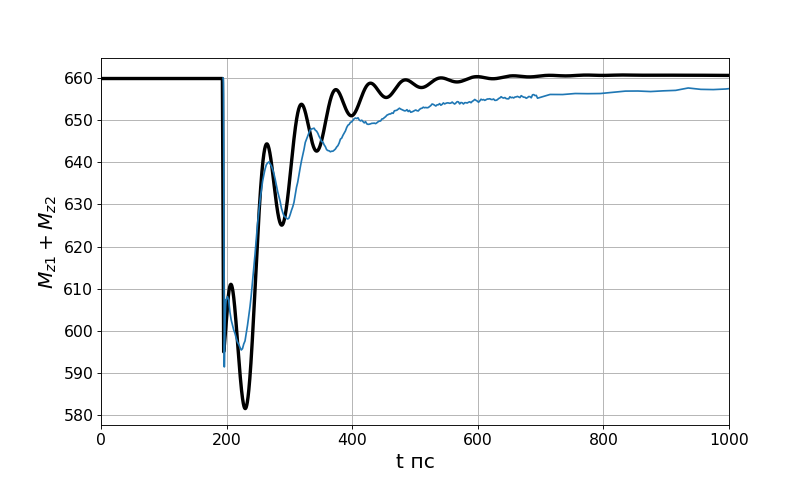

In [46]:
%matplotlib notebook
plt.subplots(figsize = (10, 6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


#what_to = df.z2 + df.z1
what_to = df.z1
#what_to = df.x2

plt.plot(df.t*1e12, what_to, label="симуляция", linewidth=3,color='k')

plt.plot(data_3825['t'] + 195, 660. + data_3825['dtet']*0.23e6)

plt.xlabel("t пс", fontsize=18)
plt.ylabel(r"$M_{z1}+M_{z2}$", fontsize=18)
#plt.plot(df.t, df.z1)
#plt.plot(df.t, df.z2)
plt.xlim(0, 1000)
plt.grid(True)


In [14]:
from scipy.optimize import curve_fit
import matplotlib.patheffects as pe

#---------WARNING----------
print("WARNING")
M_t0 = 210e-12
print("M_t0 set to {}".format(M_t0))
print()
#---------WARNING----------

def func3(x, fi0, f, tau1, tau2, tau3, A1, A2, A3, C):
    #       1-oscillations                                      2-M relaxation              3-Ku relaxation
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-M_t0)/tau2) + A3*np.exp(-(x-Ku_t0)/tau3)

def func2(x, fi0, f, tau1, tau2,  A1, A2, C):
    #       1-oscillations                                      2-M relaxation         
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-M_t0)/tau2) 

def func1(x, fi0, f, tau1, A1, C):
    #       1-oscillations                                      2-M relaxation         
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C


par, ss = curve_fit(
    func3,
    df.t[df.t>M_t0],
    what_to[df.t>M_t0],
    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
    #  fi0, f,   tau1,    tau2,  tau3,   A1, A2, A3, C
    p0=[0, 12e9, 25e-12, M_tau, Ku_tau, 10., -10., 0., 660.],
    maxfev=1000
)

#par, ss = curve_fit(
#    func2,
#    df.t[df.t>M_t0],
#    what_to[df.t>M_t0],
#    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
#    #   fi0, f,   tau1,    tau2,   A1,  A2,  C
#    p0=[0, 12e9, 100e-12, 10e-12, 50., -5., 650.],
#    maxfev=1000
#)


#par, ss = curve_fit(
#    func1,
#    df.t[df.t>M_t0],
#    what_to[df.t>M_t0],
#    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
#    #  fi0, f,   tau1,    tau2,  tau3,   A1, A2, A3, C
#    #p0=[0, 60e9, 25-12, M_tau, Ku_tau, 0.1., 1., 0., 400.],
#    p0=[0, 15e9, 25e-12, 1., 475.],
#    maxfev=1000,
#)

print(par)
print("f={} GHz".format(par[1]*1e-9))
print("tau_f={} ps".format(par[2]*1e12))

plt.plot(df.t[df.t>M_t0]*1e12, func3(df.t[df.t>M_t0], *par), '-.', label='апроксимация', linewidth=2, color='red')
#plt.plot(df.t[df.t>M_t0]*1e12, func2(df.t[df.t>M_t0], *par), linestyle='-', linewidth=2, color='red', label='апроксимация')
#plt.plot(df.t[df.t>M_t0]1e12, func1(df.t[df.t>M_t0], *par))

plt.legend(fontsize=18)

WARNING
M_t0 set to 2.1e-10

[ 4.96801124e+00 -1.83759046e+10  8.14160143e-11  4.03064381e-10
  4.53830772e-11  3.97502910e+02 -1.50722888e+01 -6.82726413e+01
  6.59311535e+02]
f=-18.375904627568737 GHz
tau_f=81.41601428394864 ps


In [47]:
t_eval = df.t
MsFrT_eval = MsFrT(t_eval)
st_t = []
st_ang1 = []
st_ang2 = []
st_z1 = []
st_z_sum = []

for i in range(0, len(t_eval), 100):
    angles = st_state.get_angles_optimize(
        MsFrT_eval[i], MsFrT_eval[i],
        film_inst.l1.Ku_1ord_l(t_eval[i]), film_inst.l2.Ku_1ord_l(t_eval[i]),
        film_inst.l1.st.Ku_2ord, film_inst.l2.st.Ku_2ord,
        film_inst.J,
        film_inst.l1.st.t, film_inst.l2.st.t,
        Hext,
        tol=1e-2,
        #bounds= None, #default full range
        bounds = [(0, Hext_tet), (0, 2*np.pi), (np.deg2rad(120), np.pi), (0, 2*np.pi)] #for local minimums
    )
    st_t.append(t_eval[i])
    st_ang1.append(angles[0])
    st_ang2.append(angles[1])
    st_z1.append(MsFrT_eval[i]*np.cos(angles[0]))

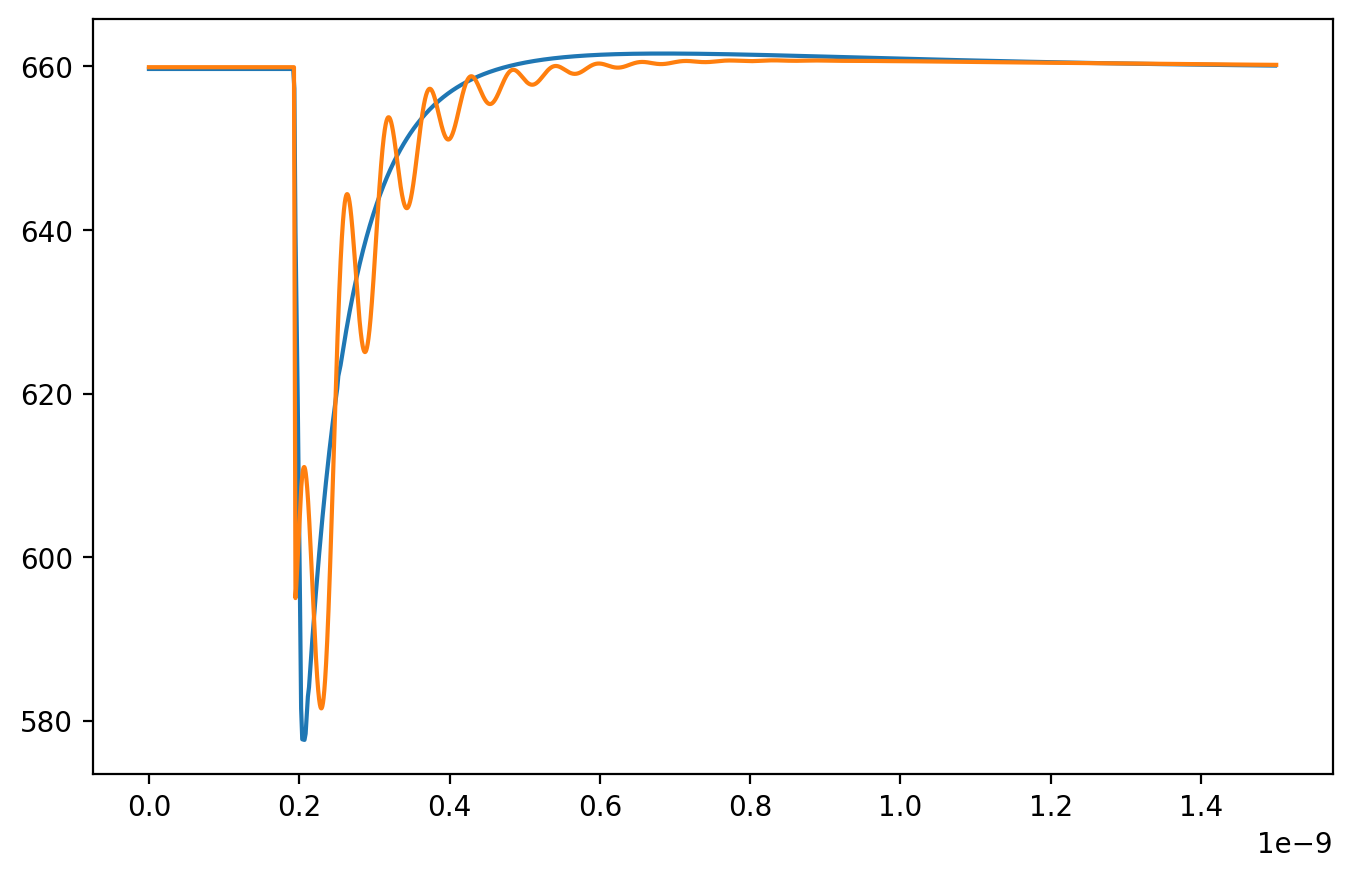

In [48]:
%matplotlib inline
plt.figure(figsize=(8, 5), dpi=200)
plt.plot(st_t, st_z1)
plt.plot(df.t, df.z1)

17.499825

'delta: 1.2499875'

<IPython.core.display.Javascript object>


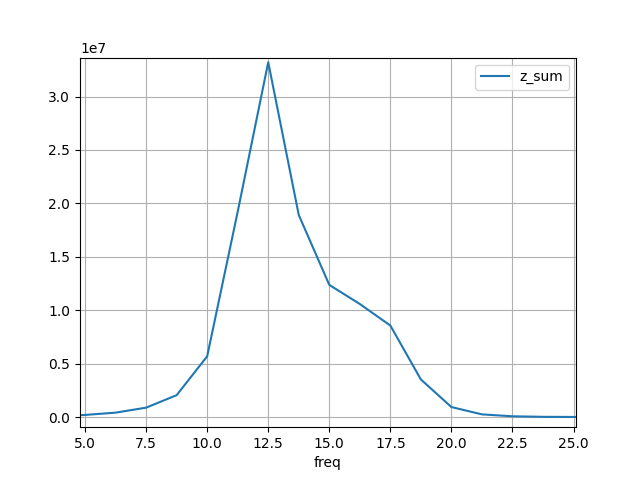

In [336]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x1','y1','z1','x2','y2','z2'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:200] * 1e-9

column_names = ['x1','y1','z1','x2','y2','z2']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:200]**2

freq_df["z_sum"] = np.abs(np.fft.fft(df.z1 + df.z2))[1:200]**2

display(freq_df['freq'][freq_df['z1'].argmax()])
display("delta: {}".format(freq_df.freq[1]-freq_df.freq[0]))
#freq_df.plot(x='freq', y=['x1','y1', 'z1', 'x2', 'y2', 'z2'])
freq_df.plot(x='freq', y=['z_sum'])
plt.grid(True)

In [25]:
%matplotlib notebook
#for now not valid for dynamic parameters
Es_of_tragectory = st_state.Es_lamb(
    df.x1, df.y1, df.z1,
    df.x2, df.y2, df.z2,
    Hext[0], Hext[1], Hext[2],
    film_inst.l1.st.Ku, film_inst.l2.st.Ku,
    film_inst.J,
    film_inst.l1.st.t, film_inst.l2.st.t
)

Es_of_tragectory.plot(figsize = (9,3))
plt.grid(True)


AttributeError: 'StaticMaterial' object has no attribute 'Ku'

<IPython.core.display.Javascript object>


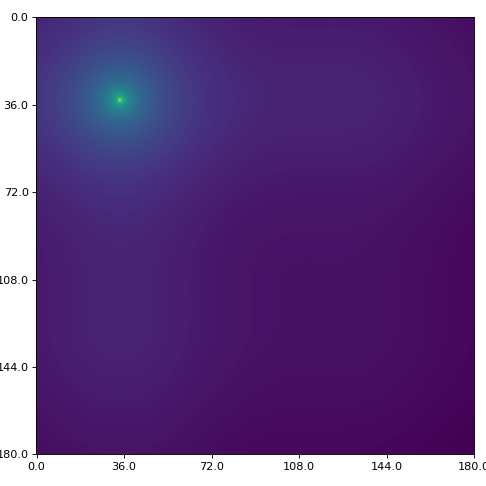

||H|| = 3000.0


In [146]:
%matplotlib notebook

st_state.plot_energy(
    film_inst,
    Hext,
    
    N = 1000,
    ang0_diap_grad = np.array([0., 180.]),
    ang1_diap_grad = np.array([0., 180.]),
    sign = -1
)
print("||H|| = {}".format(Hext_abs))

<IPython.core.display.Javascript object>


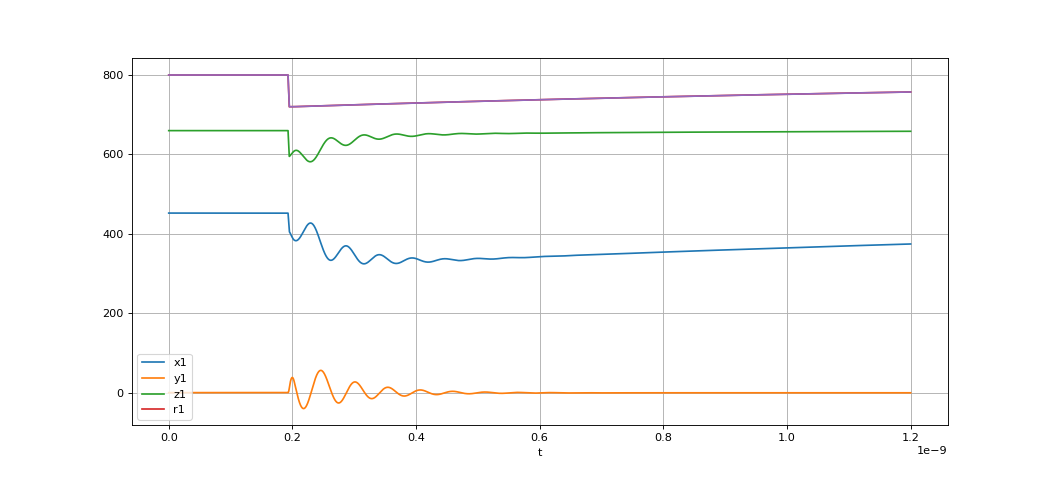

In [37]:
%matplotlib notebook

df.plot(x='t', y=['x1', 'y1', 'z1', 'r1'], figsize = (13, 6))
plt.grid(True)

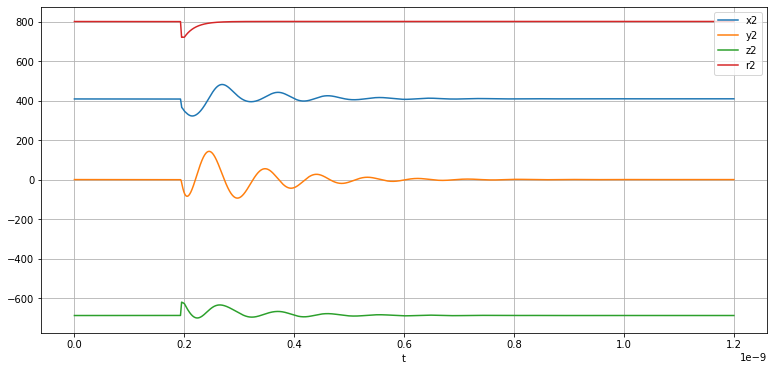

In [18]:
%matplotlib inline

df.plot(x='t', y=['x2', 'y2', 'z2', 'r2'], figsize = (13, 6))
plt.grid(True)

# Legacy Code

In [14]:
Heff_function(M01, M02, film_inst, 0)

(array([-1097.38839482,     0.        , -2645.81983107]),
 array([-1097.38839482,     0.        , -2645.81983107]))

<IPython.core.display.Javascript object>


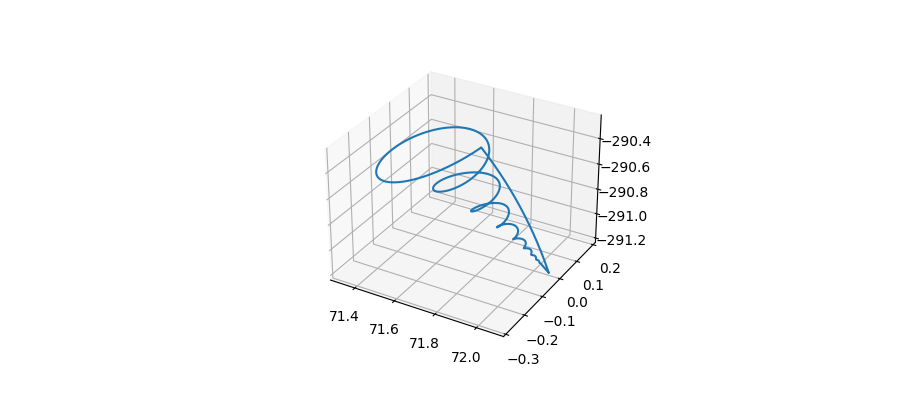

In [37]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

In [6]:
%load_ext jupyter_spaces

In [91]:
%%space space1

S = CoordSys3D('S')

Mx, My, Mz = symbols("M_x M_y M_z")
M = S.i*Mx + S.j*My + S.k*Mz

Hx, Hy, Hz = symbols("H_x H_y H_z")
H = S.i*Hx + S.j*Hy + S.k*Hz

Ku = symbols("K_u")

sin_tet2 = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
Ev = -H.dot(M) + 2*sym.pi*(M.dot(S.k)**2) + Ku*sin_tet2

varset = (
    Mx, My, Mz,
    Hx, Hy, Hz,
    Ku
)
Ev_lamb = lambdify(varset, Ev)



-H_x*M_x - H_y*M_y - H_z*M_z + K_u*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2) + 2*pi*M_z**2

In [ ]:
%%space space2
